## Orthopedic Patient classification with the bivariate Gaussian

We will use two features to classify patients into one of 3 categories (normal, disk hernia or spondilolysthesis)
by modeling each class by a **bivariate Gaussian**.

## 1. Load in the data set

This data set was obtained with thanks from: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


We start by loading in the Orthopedic Patient data set. 

Each patient is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is used for the class labels: (60)DH (Disk Hernia), (150) Spondylolisthesis (SL), (100) Normal (NO). 

There are 310 data points. We will divide this into 226 training points and 83 test points.

In [1]:
# Standard includes
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Useful module for dealing with the Gaussian density
from scipy.stats import norm, multivariate_normal 

# Useful module for checking accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 

# installing packages for interactive graphs
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider



In [2]:
# Load data set.
data = pd.read_csv('column_3C.dat', delimiter=' ')

# Names of features
featurenames = ['pelvic incidence', 'pelvic tilt', 'lumbar lordosis angle', 'sacral slope', 'pelvic radius', 'grade of spondylolisthesis', 'Class'] 
data.columns = featurenames


# Split 310 instances into training set (trainx, trainy) of size 221 and test set (testx, testy) of size 88
np.random.seed(0)
msk = np.random.rand(len(data)) < 0.75

#Train Set
train = data[msk]
trainx = train[train.columns[0:6]]
trainy = train[train.columns[6]]

#Test Set
test = data[~msk]
testx = test[test.columns[0:6]]
testy2 = test[test.columns[6]]
testy = test[test.columns[6]]

       
#print(testy.size)
#print(testy.head())
#print((trainx.iloc[:,5]))


## 2. Look at the distribution of two biomedical attributes

Our goal is to plot the distribution of two features from a particular class of orthopedic patient. We will use several helper functions for this.

The first helper function fits a Gaussian to a data set, restricting attention to specified features.
It returns the mean and covariance matrix of the Gaussian.

In [3]:
# Fit a Gaussian to a data set using the selected features
def fit_gaussian(x, features):
    mu = x.iloc[:,features].mean()
    covar = x.iloc[:,features].cov()
    return mu, covar




In [4]:
def fit_multivariate_gaussian(x,y,label):
    
           
#    if label == 1: 
 #       NewLabel = "DH"
 #   elif label == 2:
 #      NewLabel = "SL"
 #    elif label == 3:
 #       NewLabel = "NO"
        
    temp_x = x[y==label]
    mu = temp_x.iloc[:,:].mean()
    covar = temp_x.iloc[:,:].cov()

    #mu = x.iloc[:,:].mean()
    #covar = x.iloc[:,:].cov()
    return mu, covar

For example, let's look at the Gaussian we get for patients with DH (Disk Hernia), using features 1 ('Pelvic') and 3 ('Sacral Slope').

In [5]:
label = "NO"
mu, covar = fit_multivariate_gaussian(trainx[train["Class"]==label],trainy,"NO")
print("Mean:\n" + str(mu))
print("Covariance matrix:\n" + str(covar))

Mean:
pelvic incidence               50.344857
pelvic tilt                    12.603000
lumbar lordosis angle          42.951429
sacral slope                   37.741286
pelvic radius                 124.957429
grade of spondylolisthesis      1.098143
dtype: float64
Covariance matrix:
                            pelvic incidence  pelvic tilt  \
pelvic incidence                  128.145559    41.809788   
pelvic tilt                        41.809788    38.302497   
lumbar lordosis angle              82.279713    16.272051   
sacral slope                       86.328923     3.505854   
pelvic radius                     -55.618606   -23.034547   
grade of spondylolisthesis          9.821771     5.711451   

                            lumbar lordosis angle  sacral slope  \
pelvic incidence                        82.279713     86.328923   
pelvic tilt                             16.272051      3.505854   
lumbar lordosis angle                  115.590012     66.007443   
sacral slope      

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


Class
DH    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
NO    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
SL    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

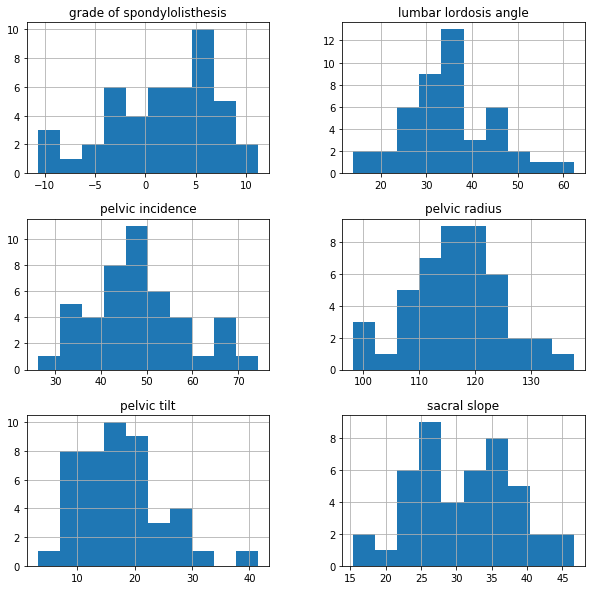

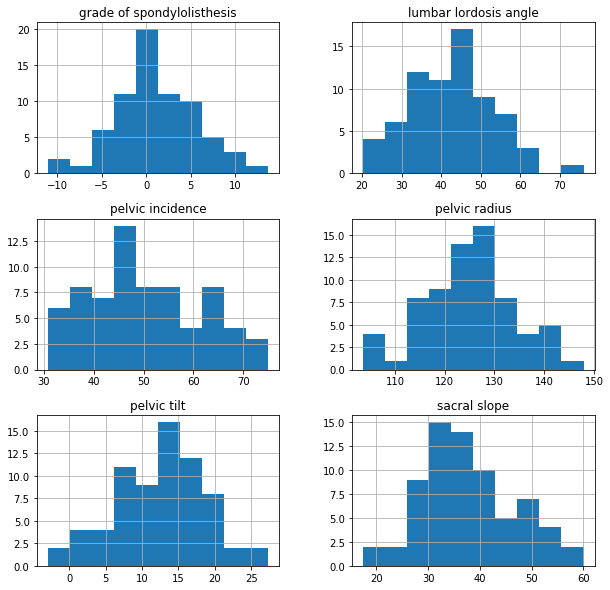

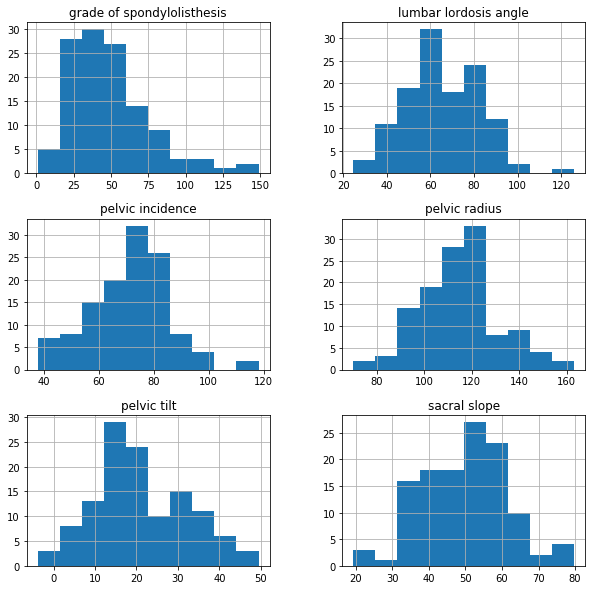

In [6]:
train.groupby('Class').hist(figsize=(10, 10))

In [8]:
f1 = 1  #Pelvic Tilt
f2 = 3  #Sacral Slope
label = "DH" #Patients with Disk Hernia
mu, covar = fit_gaussian((trainx[train["Class"]==label]), [f1,f2])

print("Mean:\n" + str(mu))
print("Covariance matrix:\n" + str(covar))


Mean:
pelvic tilt     17.389333
sacral slope    30.960889
dtype: float64
Covariance matrix:
              pelvic tilt  sacral slope
pelvic tilt     56.061256      3.344192
sacral slope     3.344192     53.075931


Next, we will construct a routine for displaying points sampled from a two-dimensional Gaussian, as well as a few contour lines. Part of doing this involves deciding what range to use for each axis. We begin with a little helper function that takes as input an array of numbers (values along a single feature) and returns the range in which these numbers lie.

In [10]:
# Find the range within which an array of numbers lie, with a little buffer
def find_range(x):
    lower = min(x)
    upper = max(x)
    width = upper - lower
    lower = lower - 0.2 * width
    upper = upper + 0.2 * width
    return lower, upper



Next we define a routine that plots a few contour lines of a given two-dimensional Gaussian.
It takes as input:
* `mu`, `cov`: the parameters of the Gaussian
* `x1g`, `x2g`: the grid (along the two axes) at which the density is to be computed
* `col`: the color of the contour lines

In [11]:
def plot_contours(mu, cov, x1g, x2g, col):
    rv = multivariate_normal(mean=mu, cov=cov)
    z = np.zeros((len(x1g),len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            z[j,i] = rv.logpdf([x1g[i], x2g[j]]) 
    sign, logdet = np.linalg.slogdet(cov)
    normalizer = -0.5 * (2 * np.log(6.28) + sign * logdet)  
    for offset in range(1,4):
        plt.contour(x1g,x2g,z, levels=[normalizer - offset], colors=col, linewidths=2.0, linestyles='solid')
  

The function **two_features_plot** takes an input two features and a label, and displays the distribution for the specified Class (DH, NO, SL) and pair of features.

The first line allows you to specify the parameters interactively using sliders.

In [12]:
@interact_manual( f1=IntSlider(1,0,5,1), f2=IntSlider(3,0,5,1), label=IntSlider(1,1,3,1) )

def two_features_plot(f1,f2,label):
    if f1 == f2: # we need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    
    if label == 1: 
        NewLabel = "DH"
    elif label == 2:
        NewLabel = "SL"
    elif label == 3:
        NewLabel = "NO"
   
        

    temp_trainx = trainx[train["Class"]==NewLabel]
 
    # Set up plot
    x1_lower, x1_upper = find_range(temp_trainx[temp_trainx.columns[f1]])
    x2_lower, x2_upper = find_range(temp_trainx[temp_trainx.columns[f2]])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
   
    # Plot the training points along the two selected features
    plt.plot(temp_trainx[temp_trainx.columns[f1]], temp_trainx[temp_trainx.columns[f2]], 'ro')


    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

  
    # Now plot a few contour lines of the density
    mu, cov = fit_gaussian((trainx[train["Class"]==NewLabel]), [f1,f2])
    plot_contours(mu, cov, x1g, x2g, 'k')
    
  
    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Class ' + str(NewLabel), fontsize=14, color='blue')
    plt.show()
    


interactive(children=(IntSlider(value=1, description='f1', max=5), IntSlider(value=3, description='f2', max=5)…

## 3. Fit a Gaussian to each class

We now define a function that will fit a Gaussian generative model to the three classes, restricted to a given list of features. The function returns:
* `mu`: the means of the Gaussians, one per row
* `covar`: covariance matrices of each of the Gaussians
* `pi`: list of three class weights summing to 1

In [13]:
# Assumes y takes on values 1,2,3
def fit_generative_model(x, y, features):
    k = 3 # number of classes
    d = len(features) # number of features
    mu = np.zeros((k+1,d)) # list of means
    covar = np.zeros((k+1,d,d)) # list of covariance matrices
    pi = np.zeros(k+1) # list of class weights
    for label in range(1,k+1):
        if label == 1: 
            NewLabel = "DH"
        elif label == 2:
            NewLabel = "SL"
        elif label == 3:
            NewLabel = "NO"
        temp_trainx = x[y==NewLabel]
        mu[label,:], covar[label,:,:] = fit_gaussian(temp_trainx, features)
        pi[label] = float(len(temp_trainx))/float(len(y))
    return mu, covar, pi

Now we will plot the three Gaussians.

In [14]:
@interact( f1=IntSlider(0,0,5,1), f2=IntSlider(6,0,5,1) )
def three_class_plot(f1,f2):
    if f1 == f2: # we need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    
  
    
    # Set up plot
    x1_lower, x1_upper = find_range(trainx[trainx.columns[f1]])
    x2_lower, x2_upper = find_range(trainx[trainx.columns[f2]])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        if label == 1: 
            NewLabel = "DH"
        elif label == 2:
            NewLabel = "SL"
        elif label == 3:
            NewLabel = "NO"
        temp_trainx = trainx[train["Class"]==NewLabel]
        plt.plot(temp_trainx[temp_trainx.columns[f1]], temp_trainx[temp_trainx.columns[f2]], marker='o', ls='None', c=colors[label-1])

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Show the Gaussian fit to each class, using features f1,f2
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    for label in range(1,4):
        gmean = mu[label,:]
        gcov = covar[label,:,:]
        plot_contours(gmean, gcov, x1g, x2g, colors[label-1])

    # Finally, display
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.title('Vetebral Column Data', fontsize=14, color='blue')
    plt.show()

interactive(children=(IntSlider(value=0, description='f1', max=5), IntSlider(value=5, description='f2', max=5)…

## 4. Predict labels for the test points

How well we can predict the class (DH, SL, NO) based just on these two features?

We start with a testing procedure that is analogous to what we developed in the 1-d case.

In [15]:
# Now test the performance of a predictor based on a subset of features
import string
@interact( f1=IntSlider(0,0,5,1), f2=IntSlider(1,0,5,1) )
def test_model(f1, f2):
    if f1 == f2: # need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    features= [f1,f2]
    mu, covar, pi = fit_generative_model(trainx, trainy, features)
    
   
    
    k = 3 # Labels 1,2,...,k
    nt = len(testy) # Number of test points
    score = np.zeros((nt,k+1))
    for i in range(0,nt):
        for label in range(1,k+1):
            score[i,label] = np.log(pi[label]) + multivariate_normal.logpdf(testx.iloc[i,features], mean=mu[label,:], cov=covar[label,:,:])
    predictions = np.argmax(score[:,1:4], axis=1) + 1
    # Finally, tally up score
    
    #Initializing empty array and setting it to allow strings of unlimited length
    NewPredictions = np.empty(predictions.shape, dtype=object)
    
    #Converting numbers to strings
    for i in range(len(predictions)):
        if predictions[i] == 1: 
            NewPredictions[i] = "DH"
        elif predictions[i] == 2:
            NewPredictions[i] = "SL"
        elif predictions[i] == 3:
            NewPredictions[i] = "NO"
        
    errors = np.sum(NewPredictions != testy)
    print("Test error using feature(s): "),
    for f in features:
        print("'" + featurenames[f] + "'" + " "),
    print
    print("Errors: " + str(errors) + "/" + str(nt))# Now test the performance of a predictor based on a subset of features
   
    print("Percentage Error is: "+ "%.2f" % (errors/len(predictions)*100)+ "%")

interactive(children=(IntSlider(value=0, description='f1', max=5), IntSlider(value=1, description='f2', max=5)…

### <font color="magenta">Quick Observations</font>

Different pairs of features yield different test errors.
* The smallest achievable test error of 22% was achieved from f1(3) 'sacral slope' and f2(5) 'grade of spondylolisthesis'



## 5. The decision boundary 

The function **show_decision_boundary** takes as input two features, builds a classifier based only on these two features, and shows a plot that contains both the training data and the decision boundary.

To compute the decision boundary, a dense grid is defined on the two-dimensional input space and the classifier is applied to every grid point. The built-in `pyplot.contour` function can then be invoked to depict the boundary.

In [16]:
@interact( f1=IntSlider(3,0,5,1), f2=IntSlider(5,0,5,1) )

def show_decision_boundary(f1,f2):
    # Fit Gaussian to each class
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    
    # Set up dimensions of plot
    x1_lower, x1_upper = find_range(trainx[trainx.columns[f1]])
    x2_lower, x2_upper = find_range(trainx[trainx.columns[f2]])
    plt.xlim([x1_lower,x1_upper])
    plt.ylim([x2_lower,x2_upper])

    # Plot points in training set
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        if label == 1: 
            NewLabel = "DH"
        elif label == 2:
            NewLabel = "SL"
        elif label == 3:
            NewLabel = "NO"
        temp_trainx = trainx[train["Class"]==NewLabel]
        plt.plot(temp_trainx[temp_trainx.columns[f1]],temp_trainx[temp_trainx.columns[f2]], marker='o', ls='None', c=colors[label-1])
     
                             
    # Define a dense grid; every point in the grid will be classified according to the generative model
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Declare random variables corresponding to each class density
    random_vars = {}
    for label in range(1,4):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])

    # Classify every point in the grid; these are stored in an array Z[]
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            scores = []
            for label in range(1,4):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1

    # Plot the contour lines
    plt.contour(x1g,x2g,Z.T,3,cmap='seismic')
    
    
    # Finally, show the image
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

interactive(children=(IntSlider(value=3, description='f1', max=5), IntSlider(value=5, description='f2', max=5)…

Let's use the function above to draw the decision boundary using features 3 ('Sacral Slope') and 5 ('Grade of Spondyliosisthesis').

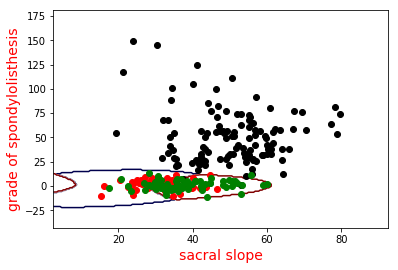

In [15]:
show_decision_boundary(3,5)

### <font color="magenta">Fast exercise 3</font>

Produce a plot similar to that of **show_decision_boundary**, but in which just the **test** data is shown.
Look back at your answer to *Fast exercise 1*. Is it corroborated by your plot? Are the errors clearly visible?

In [17]:
@interact( f1=IntSlider(3,0,5,1), f2=IntSlider(5,0,5,1) )
def show_decision_boundary(f1,f2):
    # Fit Gaussian to each class
    mu, covar, pi = fit_generative_model(trainx, trainy, [f1,f2])
    
    # Set up dimensions of plot
    x1_lower, x1_upper = find_range(testx[testx.columns[f1]])
    x2_lower, x2_upper = find_range(testx[testx.columns[f2]])
    plt.xlim([x1_lower,x1_upper])
    plt.ylim([x2_lower,150])

    # Plot points in training set
    colors = ['r', 'k', 'g']
    for label in range(1,4):
        if label == 1: 
            NewLabel = "DH"
        elif label == 2:
            NewLabel = "SL"
        elif label == 3:
            NewLabel = "NO"
        temp_testx = testx[test["Class"]==NewLabel]
        plt.plot(temp_testx[temp_testx.columns[f1]],temp_testx[temp_testx.columns[f2]], marker='o', ls='None', c=colors[label-1])
     
                             
    # Define a dense grid; every point in the grid will be classified according to the generative model
    res = 200
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Declare random variables corresponding to each class density
    random_vars = {}
    for label in range(1,4):
        random_vars[label] = multivariate_normal(mean=mu[label,:],cov=covar[label,:,:])

    # Classify every point in the grid; these are stored in an array Z[]
    Z = np.zeros((len(x1g), len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            scores = []
            for label in range(1,4):
                scores.append(np.log(pi[label]) + random_vars[label].logpdf([x1g[i],x2g[j]]))
            Z[i,j] = np.argmax(scores) + 1

    # Plot the contour lines
    plt.contour(x1g,x2g,Z.T,3,cmap='seismic')
    
    
    # Finally, show the image
    plt.xlabel(featurenames[f1], fontsize=14, color='red')
    plt.ylabel(featurenames[f2], fontsize=14, color='red')
    plt.show()

interactive(children=(IntSlider(value=3, description='f1', max=5), IntSlider(value=5, description='f2', max=5)…

## 3. MULTIVARIATE GAUSSIAN

In [18]:
def fit_multivariate_generative_model(x,y):
    k = 3  # labels 1,2,...,k
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k+1,d))
    sigma = np.zeros((k+1,d,d))
    pi = np.zeros(k+1)
   
    for label in range(1,k+1):
        if label == 1: 
            NewLabel = "DH"
        elif label == 2:
            NewLabel = "SL"
        elif label == 3:
            NewLabel = "NO"
        
        temp_trainx = x[y==NewLabel]
        mu[label], sigma[label] = fit_multivariate_gaussian(x,y,NewLabel)
        pi[label] = float(len(temp_trainx))/float(len(y))
             
    return mu, sigma,pi

In [19]:
# Fit a Gaussian generative model to the training data

mu, sigma, pi = fit_multivariate_generative_model(trainx,trainy)


In [20]:
# Now test the performance of a predictor based on a subset of features
def test_multivariate_model(mu, sigma, pi, features, tx, ty):
    ###
    sub_mu = mu[:,features]
    sub_cov = sigma[:,:,features]
    k = 3 # Labels 1,2,...,k
    nt = len(ty) # Number of test points
    score = np.zeros((nt,k+1))
    second_score = np.zeros((nt,k+1))
    toreject = np.zeros(nt)
    for i in range(0,nt):
         for label in range(1,k+1):
            score[i,label] = (pi[label]) + multivariate_normal.logpdf(tx.iloc[i,features], mean=sub_mu[label,:], cov=sub_cov[label,features,:])
            if score[i,label] < -100:
                toreject[i] = 1
            else:
                toreject[i] = 0
            

    import scipy
    #print(scipy.stats.describe(score))
    
    #Predictions without rejected samples
    predictions = np.argmax(score[:,1:6], axis=1) + 1
    
     
    # Finally, tally up score
    #Initializing empty array and setting it to allow strings of unlimited length   
    NewPredictions = np.empty(predictions.shape, dtype=object)
    
    #Converting numbers to strings
    for i in range(len(predictions)):
        if predictions[i] == 1: 
            NewPredictions[i] = "DH"
        elif predictions[i] == 2:
            NewPredictions[i] = "SL"
        elif predictions[i] == 3:
            NewPredictions[i] = "NO"
        
    #Use for 2-class predictions    
    #import string
    #newtesty=testy.replace(("DH","SL"), "AB")       
    #errors = np.sum(NewPredictions != newtesty)
    
    errors = np.sum(NewPredictions != ty)
     
    #_______________________Including REJECTION SAMPLING_______________________________________________________
    #Finding the range of the scores with a view to reject samples with low probabilities: 
    #https://academic.oup.com/bioinformatics/article/24/17/1889/263502
    #Creating an array without low probability samples           
    second_score = score[toreject == 0]
    #print(second_score.size)
    #Predictions wit rejected samples
    second_predictions = np.argmax(second_score[:,1:6], axis=1) + 1
    
    second_NewPredictions = np.empty(second_predictions.shape, dtype=object)
    
    #Converting numbers to strings
    for i in range(len(second_predictions)):
        if second_predictions[i] == 1: 
            second_NewPredictions[i] = "AB"
        elif second_predictions[i] == 2:
            second_NewPredictions[i] = "AB"
        elif second_predictions[i] == 3:
            second_NewPredictions[i] = "NO"
            
    #second_testy = newtesty[toreject == 0]     
    second_testy = ty[toreject == 0]  
    second_errors = np.sum(second_NewPredictions != second_testy)        
            
    #_________________________________________________________________________________________________________         
         
    print("Test error using feature(s): "),
    for f in features:
        print("'" + featurenames[f] + "'" + " "),
    
    print("Errors: " + str(errors) + "/" + str(nt))# Now test the performance of a predictor based on a subset of features
    print("Percentage Error is: "+ "%.2f" % (errors/len(predictions)*100)+ "%")
    
    print("----------------------------------------------------------------------------------")
    print("Errors after rejection sampling: " + str(second_errors) + "/" + str(len(second_predictions)))# Now test the performance of a predictor based on a subset of features
    print("Percentage Error after rejection sampling is: "+ "%.2f" % (second_errors/len(second_predictions)*100)+ "%")
    #
    
    #Accuracy & Confusion
    accuracy_score(y_true = ty, y_pred = NewPredictions)
    confusion_matrix(y_true = ty, y_pred = NewPredictions)
    print(classification_report(y_true = ty, y_pred = NewPredictions))

In [32]:
test_multivariate_model(mu, sigma, pi, [1,4,3,5], testx, testy)

260
Test error using feature(s): 
'pelvic tilt' 
'pelvic radius' 
'sacral slope' 
'grade of spondylolisthesis' 
Errors: 13/72
Percentage Error is: 18.06%
----------------------------------------------------------------------------------
Errors after rejection sampling: 45/65
Percentage Error after rejection sampling is: 69.23%
             precision    recall  f1-score   support

         DH       0.65      0.79      0.71        14
         NO       0.91      0.67      0.77        30
         SL       0.85      1.00      0.92        28

avg / total       0.83      0.82      0.82        72

